# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Introducción al aprendizaje automático

### Trabajo práctico entregable - Grupo 22 - Parte 2
Armado de un esquema de aprendizaje automático

**Integrantes:**
- Chevallier-Boutell, Ignacio José
- Ribetto, Federico Daniel
- Rosa, Santiago
- Spano, Marcelo

**Seguimiento:** Meinardi, Vanesa


In [57]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
import sklearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

def plot_confusion_matrix(cmatrix):

    return sns.heatmap(cmatrix , 
                      annot=True, 
                      fmt='.2f', 
                      cmap="YlGnBu", 
                      vmin=0.0, 
                      vmax=1.0 , 
                      xticklabels=[0,1],
                      yticklabels=[0,1])



## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

<Axes: >

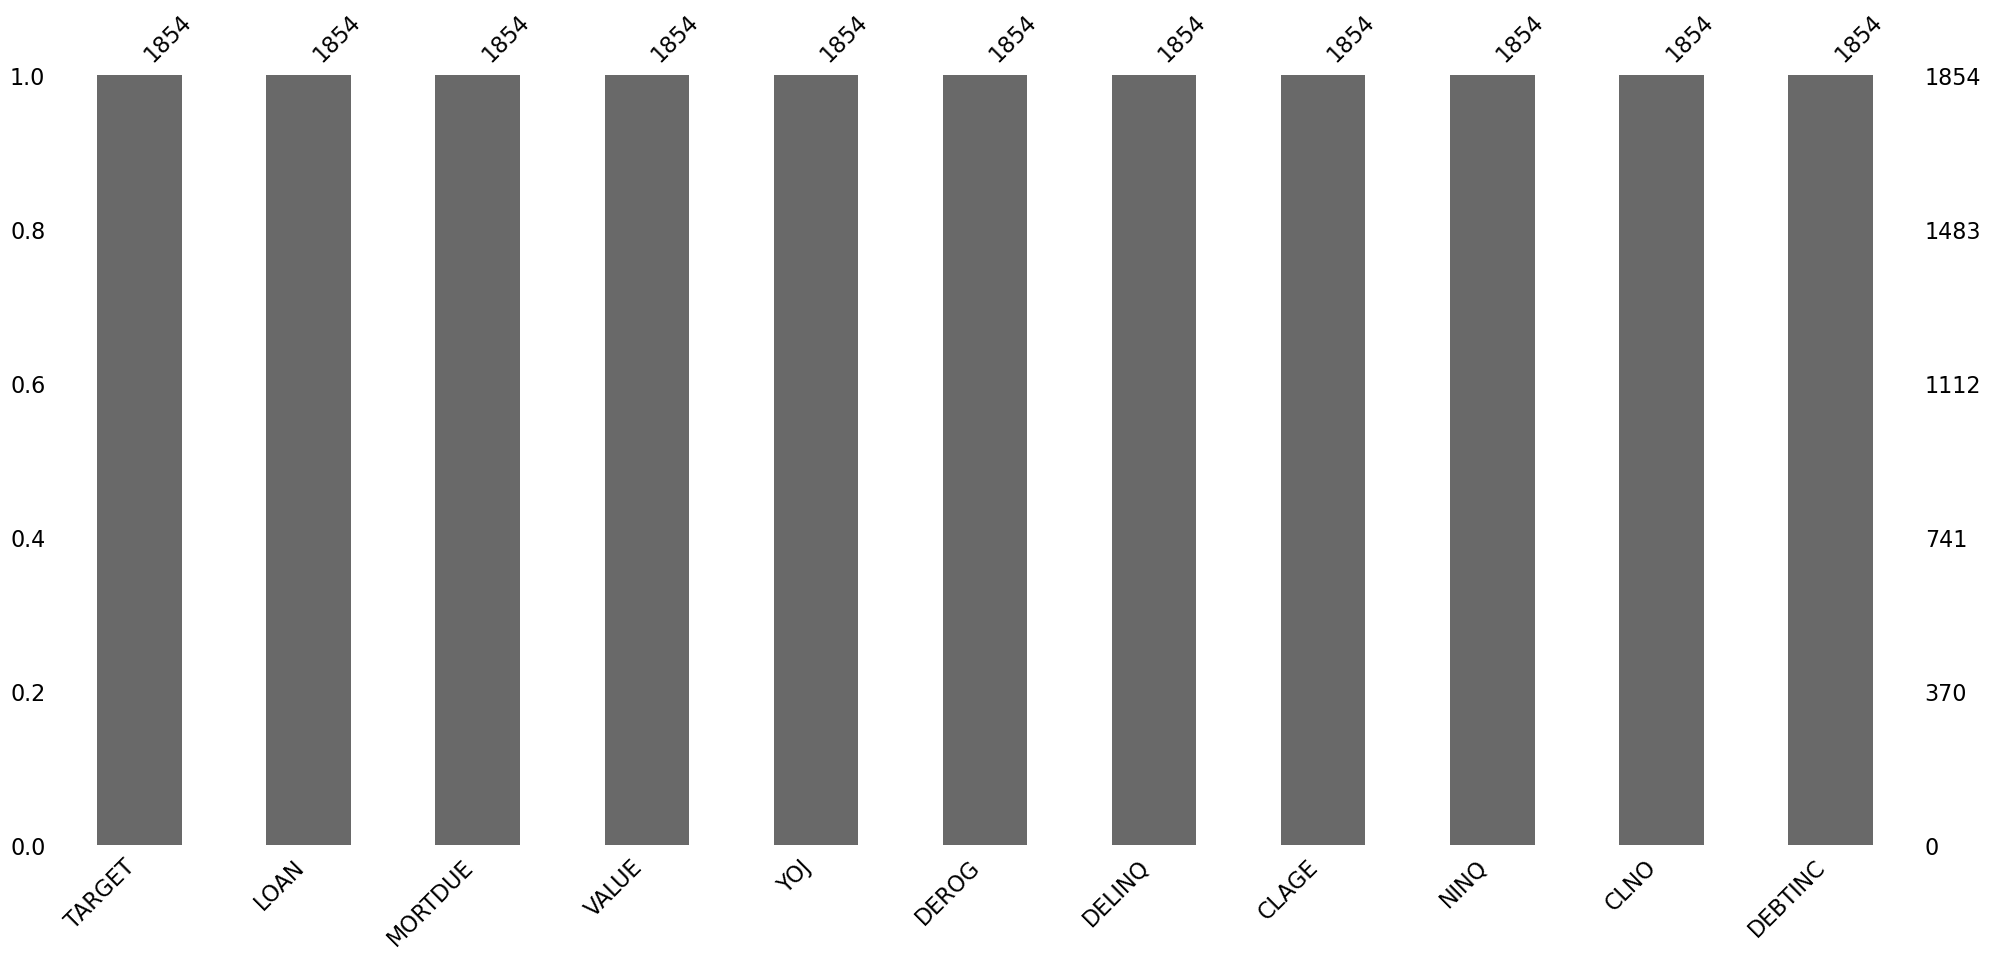

In [2]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

msno.bar(dataset)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Antes de responder a las preguntas, veamos la descripción del dataset.

# Ejercicio 1: Descripción de los datos y la tarea

Antes de responder a las preguntas, veamos la descripción del dataset (disponible en https://www.kaggle.com/ajay1735/hmeq-data).

**Contexto:**

El departamento de crédito al consumo de un banco quiere automatizar el proceso de toma de decisiones para la aprobación de líneas de crédito con garantía hipotecaria. Para hacer esto, seguirán las recomendaciones de la Ley de Igualdad de Oportunidades de Crédito para crear un modelo de puntuación de crédito estadísticamente sólido y derivado empíricamente. El modelo se basará en datos recopilados de solicitantes recientes a los que se les otorgó crédito a través del proceso actual de suscripción de préstamos. El modelo se construirá a partir de herramientas de modelado predictivo, pero el modelo creado debe ser suficientemente interpretable para proporcionar una razón para cualquier acción adversa (rechazos).

**Contenido:**

El conjunto de datos sobre el valor acumulado de la vivienda (HMEQ, por sus siglas en inglés) contiene información de línea de base y rendimiento de préstamos para 5960 préstamos sobre el valor acumulado de la vivienda recientes. El objetivo (target) (BAD) es una variable binaria que indica si un solicitante finalmente incumplió o fue gravemente moroso. Este resultado adverso ocurrió en 1189 casos (20%). Para cada solicitante se registraron 12 variables de entrada.

### Ahora pasamos a las preguntas:

**1. ¿De qué se trata el conjunto de datos?**

El dataset proviene de Kaggle y contiene datos financieros de 1854 préstamos de un banco. La idea del departamento de créditos del banco es automatizar el proceso de toma de decisiones para la aprobación de préstamos hipotecarios creando y entrenando un modelo con este dataset.

**2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?**

La variable objetivo que hay que predecir es **TARGET**, la cual indica si se le va a otorgar un crédito a la persona solicitante o no. En caso de que el cliente haya incumplido con el préstamo esta variable toma el valor 1. En cambio, si el préstamo fue reembolsado, esta variable toma el valor 0.

En el dataset provisto, la variable **TARGET** adopta el valor 0 en 1545 casos, y el valor 1 en los 309 casos restantes.

**3. ¿Qué información (atributos) hay disponible para hacer la predicción?**

Las variables disponibles en el dataset para hacer la predicción son:

* **LOAN**:    Importe del préstamo (variable numérica).
* **MORTDUE**: Cantidad adeudada en la hipoteca existente (variable numérica).
* **VALUE**:   Valor de la propiedad actual (variable numérica).
* **YOJ**:     Años de la persona en el trabajo actual (variable numérica).
* **DEROG**:   Número de reportes negativos (variable numérica).	
* **DELINQ**:  Número de líneas de crédito morosas (variable numérica).
* **CLAGE**:   Edad de la línea comercial más antigua en meses (variable numérica).
* **NINQ**:    Número de líneas de crédito recientes (variable numérica).
* **CLNO**:    Número de líneas de crédito (variable numérica).
* **DEBTINC**: Relación deuda-ingresos (variable numérica).

**4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?**

En orden de importancia: 

- **LOAN**: El tamaño del préstamo tiene que ser relevante ya que, en principio, tiene sentido suponer que mientras mayor sea el préstamo, más difícil puede ser de pagar.
- **DEROG y DELINQ**: Estas variables dan indicios directos de comportamientos negativos del solicitante.
- **DEBTINC**: Esta variable indica directamente la cantidad real de ingresos que una persona dispone. 
- **MORTDUE**: Lo que debe la persona claramente tiene que ser relevante.
- **YOJ**: Si bien no creemos que sea tan determinante, mucho tiempo en el mismo trabajo al menos implica un flujo constante de dinero.

En base al análisis del problema 1, dividimos el dataset en los conjuntos de entrenamiento y testeo, con los predictores mencionados.

In [4]:
#lista de predictores posibles:
#["LOAN","MORTDUE","VALUE","YOJ","DEROG","DELINQ","CLAGE","NINQ","CLNO","DEBTINC"]

#defino mis predictores:
predictores = ["LOAN","MORTDUE","DEBTINC","YOJ","DELINQ"]
# separamos los datos en entrenamiento (train) y testeo (testeo)
# los datos deben estar en arrays
x_values = np.array([dataset[x] for x in predictores], dtype=object).transpose()
y_values = dataset["TARGET"]  #variable a predecir
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, random_state = 78014,
                                                    test_size = 0.2, shuffle=True)

Es importante evaluar estadisticamente el comportamiento de nuestro modelo. Una posibilidad es comparar los valores predichos por el modelo con los valores observados para un conjunto relativamente grande de casos. Este conjunto es el que denominamos conjunto de "testing". 
Podemos utilizar la **matriz de confusión** para calcular las frecuencias relativas de los eventos.

Los elementos de la matriz son:

* TP - verdaderos positivos: se pronosticó el pago del cŕedito y ocurrió (aciertos, hits)
* TN - verdaderos negativos: se pronosticó el default y ocurrió (aciertos negativos)
* FN - falsos negativos o sorpresas: se pronosticó el pago del cŕedito y ocurrió un default (misses)
* FP - falsos positivos o falsa alarma: se pronosticó un default pero se pagó el crédito (false alarm)

Existen multiples índices (scores) que pueden calcularse a partir de la matriz de contingencia:

**precision** es la porción de eventos pronosticados que resultó en una correcta detección. El valor va entre 0 y 1, siendo este último el valor óptimo:

$$\text{Precision}=\frac{TP}{TP+FP}$$

**accuracy** se define como la suma de verdaderos positivos y verdaderos negativos dividida por el número total de muestras. Esto solo es exacto si el modelo está equilibrado y dará resultados inexactos si hay un desequilibrio de clases:

$$\text{Accuracy} =\frac{TP+TN}{TP+TN+FP+FN}$$


**recall** es la fracción de eventos positivos observados que fueron correctamente pronosticados. El valor va entre 0 y 1, siendo este último el valor óptimo:

$$\text{Recall} = \frac{TP}{FN+TP}$$

**F1** es una media armónica ponderada de la precisión y el recall. Toma valores entre 0 y 1, siendo 1 el mejor valor y 0 el peor.

$$ \text{F1} =2 * \frac{ \text{precision} * \text{recall}} {\text{precision} + \text{recall}} $$


Dicho todo esto, definimos una función para calcular la matriz de confusión y los scores:

In [69]:
def compute_scores_class( y_pred , y_true ) :
    
    "defino una funcion para calcular la matriz de contingencia, y varios scores"
    
    cmatrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    cmatrix_norm = cmat / np.sum(cmat)
    
    tp = cmatrix_norm[0,0]
    fp = cmatrix_norm[1,0]
    tn = cmatrix_norm[1,1]
    fn = cmatrix_norm[0,1]
    
    model_pre = tp / (tp+fp)
    model_acc = (tp+tn)/(tp+tn+fp+fn)
    model_rec = tp / ( fn + tp )
    F1 = 2 * (model_pre * model_rec) / (model_pre + model_rec)
    
    index = {"f1":F1,"precision":model_pre,"accuracy":model_acc,"recall":model_rec}
    
    return cmatrix_norm, index


# Ejercicio 2: Predicción con modelos lineales

En este ejercicio se entrenaron modelos lineales de clasificación para predecir la variable objetivo utilizando la clase SGDClassifier de scikit-learn.


## Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

El estimador ``SGDClasiffier`` implementa modelos lineales regularizados con aprendizaje de descenso de gradiente estocástico (SGD): el gradiente de la pérdida se estima cada muestra a la vez y el modelo se actualiza a lo largo del camino con un programa de fuerza decreciente (también conocido como tasa de aprendizaje).

Utilizando los hiperparámetros por defecto obtenemos los siguientes resultados para la variable **TARGET**:

In [65]:
# Escribimos los resultados obtenidos
model = SGDClassifier(random_state=0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Escribimos los resultados obtenidos
print('Predicción:')
print(y_pred)
print('*'*75)
print('Conjunto de testeo:')
print(y_test.to_numpy())

Predicción:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
***************************************************************************
Conjunto de testeo:
[0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 

Evaluemos el desempeño del clasificador. Observamos que nuestro modelo no está prediciendo correcamente la etiqueta "1" (default). Se observa en los scores que tiene una alta precisión ya que predice mu bien los casos mayoritarios "0", pero con una exactitud mucho más baja ya que no está prediciendo nunca los 1.

En la matriz vemos cómo se manifiesta el hecho de que el clasificador no haya sido capaz de predecir etiquetas "1": Existe una gran diferencia entre los elementos diagonal y no-diagonal de la fila 1. Más específicamente, vemos que el elemento (1,1) de la matriz es cero mientras que el elemento (0,1) es 0.17.

f1 : 0.8991097922848665
precision : 0.9805825242718447
accuracy : 0.816711590296496
recall : 0.8301369863013699


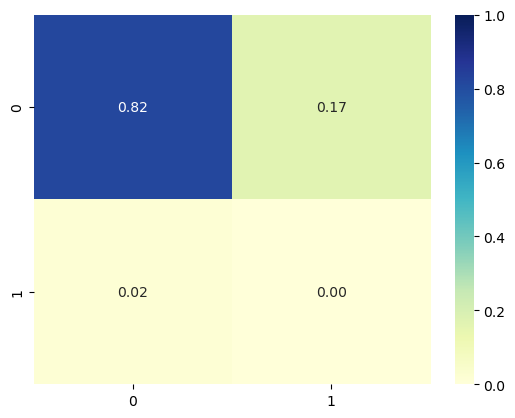

In [70]:
### Matriz de confusión:
cmat, index = compute_scores_class(y_test, y_pred)

plot_confusion_matrix(cmat)

for idx in index:
    print(idx,':',index[idx])

## Ejercicio 2.2: Ajuste de Hiperparámetros

En este ejercicio repetimos lo hecho previamente pero ahora tomando diferentes valores para un dado conjunto de hiperparámetros del modelo. En particular, modificamos las funciones de pérdida, las tasas de entrenamiento y las tasas de regularización. Esto fue llevado a cabo mediante las técnicas ``grid-search`` y ``5-fold cross-validation`` sobre el conjunto de entrenamiento con el fin de explorar muchas combinaciones posibles de valores para los hiperparámetros. 

Los scores anteriores muestran las métricas obtenidas toda la muestra. Vemos que el clasificador es mucho más preciso para la clase "0", lo cual era de esperar tras ver los resultados predichos y notando que no hay ninguna etiqueta "1" entre ellos. Esta ausencia de etiquetas "1" también es causa de que para esta clase se cumpla que ``recall`` y ``F1-score`` sean nulos y que para la clase "0" el valor de ``recall`` sea 1.0. Notar que el valor 0.92 de ``F1-score`` no difiere mucho del de ``recall``, lo cual es un indicio de que la muestra no está desbalanceada.


Finalmente, la ``accuracy`` es de 0.84. Este valor, que puede ser considerado relativamente alto, refleja lo discutido previamente respecto a la capacidad del clasificador para clasificar correctamente las etiquetas "0", sumado al hecho de que hay aproximadamente cinco veces más muestras "0" que "1" (313 para "1" vs 58 para "0").

### Validación cruzada (Cross-validation)

Al evaluar diferentes hiperparámetros para los estimadores, existe el riesgo de sobreajuste en el conjunto de prueba porque los parámetros pueden modificarse hasta que el estimador funcione de manera óptima. De esta manera, el conocimiento sobre el conjunto de prueba puede "filtrarse" en el modelo y las métricas de evaluación ya no informan sobre el rendimiento de la generalización. Para resolver este problema, se puede presentar otra parte del conjunto de datos como un "conjunto de validación": el entrenamiento continúa en el conjunto de entrenamiento, después de lo cual se realiza la evaluación en el conjunto de validación y cuando el experimento parece tener éxito, la evaluación final se puede hacer en el conjunto de prueba.

Sin embargo, al dividir los datos disponibles en tres conjuntos, reducimos drásticamente la cantidad de muestras que se pueden usar para aprender el modelo, y los resultados pueden depender de una elección aleatoria particular para el par de conjuntos (entrenamiento, validación).

Una solución a este problema es un procedimiento llamado ``validación cruzada`` (CV). Todavía se debe reservar un conjunto de prueba para la evaluación final, pero el conjunto de validación ya no es necesario al hacer CV. En el enfoque básico, llamado k-fold CV, el conjunto de entrenamiento se divide en k conjuntos más pequeños. Para cada uno de los k “folds” se sigue el siguiente procedimiento:

* Un modelo es entrenado usando $k-1$ de los folds como datos de entrenamiento;

* El modelo resultante se valida con la parte restante de los datos (es decir, se utiliza como conjunto de prueba para calcular una medida de rendimiento como la precisión).

La medida de rendimiento informada por  k-fold CV es un promedio de los valores calculados. Este enfoque puede ser computacionalmente costoso, pero no desperdicia demasiados datos, lo cual es una gran ventaja en problemas donde el número de muestras es muy pequeño.

### Validación Cruzada sobre una grilla de parámetros: GridSearchCV

Con ``GridSearchCV`` podemos hacer validación cruzada (la cual, por defecto, es estratificada) sobre una grilla de parámetros dada considerando exhaustivamente todas las combinaciones de ellos. Sklearn se encarga de todo el proceso y nos devuelve una tabla de resultados junto con el mejor clasificador obtenido. Para ello es necesario especificar una grilla de valores para los parámetros de interés dentro de un diccionario. En particular, vamos a modificar los siguientes parámetros:

* **Loss**: la función de costo. Usaremos ``hinge`` (SVM lineal), ``log_loss`` (regresión logística), ``squared_hinge`` (hinge cuadráticamente penalizado) y ``squared_error`` (error cuadrático).
* **Penalty**: término de regularización. Probaremos con ``l2`` (regularizador estándar para modelos SVM) y ``elasticnet`` (combinación de ``l2`` con la norma absoluta ``l1``).
* **Alpha**: la constante que multiplica al término de regularización. Barreremos el rango de valores [1e-5, 1e2] de forma logarítmica.

Los valores por defecto de estos parámetros son ``loss='hinge'``, ``penalty='l2'`` y ``alpha=0.0001``.

Debido al desbalance existente en el dataset, vamos a incrementar el número de "folds" a 10.

In [59]:
# SGDClassifier --> Valid parameters are: ['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon',
# 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change','n_jobs',
# 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'].

# Primero creamos una lista logarítmica de valores de alpha
alpha_list = np.ones(50)
alpha_list = np.logspace(-5, 2, 49, endpoint = True)

# Luego creamos el diccionario de parámetros de interés a explorar
param_grid = {
    'loss': ['hinge', 'log_loss','squared_hinge','squared_error'],
    'alpha': alpha_list,
    'penalty': ['l2', 'elasticnet'],
}

# Aplicación del SGDClassifier
model = SGDClassifier(random_state=0)

cv = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=8, cv=10)
cv.fit(x_train, y_train);

results = cv.cv_results_
df_results = pd.DataFrame(results)
df_results.sort_values(by=['rank_test_score']).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_loss,param_penalty,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
333,0.003294,0.000882,0.000389,0.000021,9.531619,squared_hinge,elasticnet,"{'alpha': 9.531618832347881, 'loss': 'squared_...",0.832215,0.832215,...,0.837838,0.837838,0.837838,0.831081,0.831081,0.831081,0.831081,0.833448,0.002912,1
141,0.003944,0.000791,0.000402,0.000007,0.003014,squared_hinge,elasticnet,"{'alpha': 0.003014162529877392, 'loss': 'squar...",0.832215,0.832215,...,0.837838,0.837838,0.837838,0.831081,0.831081,0.831081,0.831081,0.833448,0.002912,1
28,0.002784,0.001065,0.000428,0.000067,0.000027,squared_hinge,l2,"{'alpha': 2.7384196342643615e-05, 'loss': 'squ...",0.832215,0.832215,...,0.837838,0.837838,0.837838,0.831081,0.831081,0.831081,0.831081,0.833448,0.002912,1
301,0.003391,0.000758,0.000390,0.000011,2.487902,squared_hinge,elasticnet,"{'alpha': 2.48790236723884, 'loss': 'squared_h...",0.832215,0.832215,...,0.837838,0.837838,0.837838,0.831081,0.831081,0.831081,0.831081,0.833448,0.002912,1
73,0.004629,0.001153,0.000472,0.000055,0.000205,hinge,elasticnet,"{'alpha': 0.0002053525026457146, 'loss': 'hing...",0.832215,0.832215,...,0.837838,0.837838,0.837838,0.831081,0.831081,0.831081,0.831081,0.833448,0.002912,1
25,0.005447,0.001630,0.000508,0.000076,0.000027,hinge,elasticnet,"{'alpha': 2.7384196342643615e-05, 'loss': 'hin...",0.832215,0.832215,...,0.837838,0.837838,0.837838,0.831081,0.831081,0.831081,0.831081,0.833448,0.002912,1
284,0.002782,0.000397,0.000380,0.000005,1.271062,squared_hinge,l2,"{'alpha': 1.2710617996147457, 'loss': 'squared...",0.832215,0.832215,...,0.837838,0.837838,0.837838,0.831081,0.831081,0.831081,0.831081,0.833448,0.002912,1
330,0.007302,0.000954,0.000521,0.000030,9.531619,log_loss,l2,"{'alpha': 9.531618832347881, 'loss': 'log_loss...",0.832215,0.832215,...,0.837838,0.837838,0.837838,0.831081,0.831081,0.831081,0.831081,0.833448,0.002912,1
300,0.003740,0.001047,0.000480,0.000053,2.487902,squared_hinge,l2,"{'alpha': 2.48790236723884, 'loss': 'squared_h...",0.832215,0.832215,...,0.837838,0.837838,0.837838,0.831081,0.831081,0.831081,0.831081,0.833448,0.002912,1
331,0.004146,0.001247,0.000501,0.000012,9.531619,log_loss,elasticnet,"{'alpha': 9.531618832347881, 'loss': 'log_loss...",0.832215,0.832215,...,0.837838,0.837838,0.837838,0.831081,0.831081,0.831081,0.831081,0.833448,0.002912,1


Las 10 mejores combinaciones de parámetros quedan resumidas en la tabla anterior. En particular, la mejor combinación de parámetros es aquella dada por

In [37]:
print('Mejores parámetros:')
print(cv.best_params_)

Mejores parámetros:
{'alpha': 2.7384196342643615e-05, 'loss': 'hinge', 'penalty': 'elasticnet'}


Este conjunto de parámetros tiene asociado un score promedio de 0.83, con una desviación de 0.002.

Ahora utilizaremos estos parámetros en el SGDClassifier para analizar el conjunto de testeo.b

In [60]:
# Escribimos los resultados obtenidos
model2 = SGDClassifier(alpha = 0.12115276586285902,loss = 'hinge', penalty = 'elasticnet', random_state=0)
model2.fit(x_train, y_train)
y_pred2 = model2.predict(x_test)

print('Predicción:')
print(y_pred2)
print('*'*75)
print('Conjunto de testeo:')
print(y_test.to_numpy())

Predicción:
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
***************************************************************************
Conjunto de testeo:
[0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 

## Métricas:

### Reporte de clasificación y matriz de confusión:

Al igual que antes, hacemos un reporte de clasificación y calculamos la matriz de confusión para analizar el desempeño del clasificador.

f1 : 0.8991097922848665
precision : 0.9805825242718447
accuracy : 0.816711590296496
recall : 0.8301369863013699


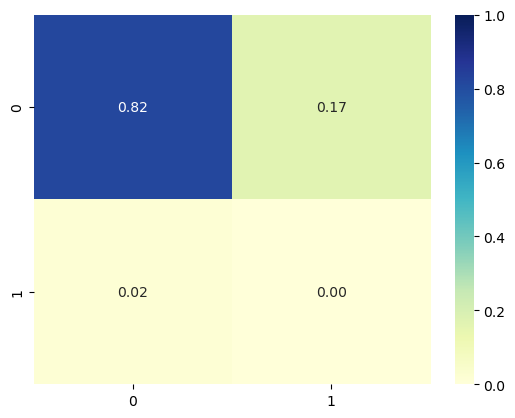

In [71]:
# Calculamos el reporte de clasificación:
#precision_score(y_test.to_numpy(), y_pred2)
#print(classification_report(y_test.to_numpy(), y_pred2))

cmat, index = compute_scores_class(y_test, y_pred2)

plot_confusion_matrix(cmat)

for idx in index:
    print(idx,':',index[idx])

Vemos que los resultados coinciden con los obtenidos en el ejercicio previo. Esto puede deberse a que el dataset está desbalanceado, favoreciendo la predicción de la etiqueta "0".

## Ejercicio 3: Árboles de Decisión


### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Definimos nuestros conjuntos de entrenamiento y evaluación con las variables predictoras que quiero usar. Corroboro que en los conjuntos de entrenamiento y evaluación, la relación de etiquetas 'default' y 'repago' se mantengan respecto del dataset total.

In [ ]:
#Corroboro que están bien distribuidos los datos
loans_d_tot = len(dataset[dataset["TARGET"]==1])
loans_r_tot = len(dataset[dataset["TARGET"]==0])
print("default/repaid total ratio:",loans_d_tot/loans_r_tot)

loans_d_train = len(y_train[y_train==1])
loans_r_train = len(y_train[y_train==0])
print("default/repaid train ratio:",loans_d_train/loans_r_train)

loans_d_test = len(y_test[y_test==1])
loans_r_test = len(y_test[y_test==0])
print("default/repaid test ratio:",loans_d_test/loans_r_test)


Entreno ahora un árbol de decisión con profundidad 2, que es la profundidad mínima donde se pronostica que se repagan algunos créditos:

In [ ]:
#Entreno el arbol
depth=1
tree_loan = DecisionTreeClassifier(max_depth = depth, splitter='best')
tree_loan.fit(x_train, y_train)
y_pred = tree_loan.predict(x_test)

tree.plot_tree(tree_loan, 
               feature_names = predictores,
               class_names = ["d","r"],   #d=default, #r=repaid
               rounded=True, 
               filled=True)

Evaluemos ahora qué tan bien se comporta nuestro modelo. 

Para eso, primero veamos la matriz de contingencia. Observamos que todos los aciertos del modelo está al pronosticar que la gente pagó su crédito, pero no detectó ningún caso de gente que terminó en default.

Esto se puede analizar mejor con los índices antes definidos:
* La exactitud, precisión y índice de acierto crítico son básicamente los mismos ya que el modelo predice en su gran mayoría sólo una clase.
* El recall es casi 1 por la misma razón, no hay verdaderos negativos.
* Qué podemos decir sobre el F1???
* El modelo es propenso a sobreestimar el default: 13% de los casos, viendo la tasa de falsas alarmas. El bias > 1 también indica este fenómeno. Hay muy pocos casos donde se pronostica un falso negativo, es decir que se le otorgaría el préstamo a alguien que no va a poder pagarlo.

In [ ]:
cmatrix, index = compute_scores_class( y_pred , y_test )

res = sns.heatmap(cmatrix , 
                  annot=True, 
                  fmt='.2f', 
                  cmap="YlGnBu", 
                  vmin=0.0, 
                  vmax=1.0 , 
                  xticklabels=[0,1],
                  yticklabels=[0,1])

for idx in index:
    print(idx,':',index[idx])

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
from sklearn.model_selection import GridSearchCV

criterion = ["gini", "entropy", "log_loss"]
max_depth = [3,4,5,6,7,8,9,10]
min_samples_leaf = [1,2,3,4,5]

#defino el modelo
tree_loan = DecisionTreeClassifier()

#defino el diccionario de parámetros para armar la grilla
params = {'criterion': criterion,'max_depth': max_depth,'min_samples_leaf': min_samples_leaf}

#Instancio el objeto de búsqueda
trees = GridSearchCV(
        estimator=tree_loan,   #mi estimador 
        param_grid=params,     #la grilla donde voy a variar los hiperparámetros
        cv=None,               #None to use 5-fold cross-validation
        n_jobs=4,              #4 búsquedas en simultáneo
        verbose=1          
        )

#realizo la búsqueda
trees.fit(x_train, y_train)

#todos los resultados:
#print(trees.cv_results_)

#mejores parámetros:
#print(trees.best_params_)

y_pred = trees.predict(x_test)
print(y_pred)
# tree.plot_tree(tree_loan, 
#                feature_names = predictores,
#                class_names = ["d","r"],   #d=default, #r=repaid
#                rounded=True, 
#                filled=True)